# Reading in the data

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random

from sklearn.datasets import load_digits
from sklearn.manifold import SpectralEmbedding, TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# pd.options.display.max_columns
pd.set_option("display.max_colwidth",200)
pd.set_option("display.max_columns",20)
pd.set_option('float_format', '{:.3f}'.format)


In [124]:
def read_data(filename=str, uid=False):

    # Read the original usage
    df = pd.read_csv(filename)

    if uid:
        df = df[df['uid'] == uid]
    
    # Drop the uid and Unnamed: 0
    df.drop('uid', axis=1, inplace=True)
    df.drop('Unnamed: 0', axis=1, inplace=True)

    # Copy a feature that will be the color map later
    color_feature = df['app_cat'].tolist()

    # -------------------------------------------------------------#
    # Get a copy without the dominating social app usage
    df_no_social = df[df['app_cat'] != 4]

    # Get color map for no social app subset
    color_feature_no_social = df_no_social['app_cat'].tolist()


    # One hot code the app category
    df = pd.concat([df, pd.get_dummies(df['app_cat'])], axis=1)
    df.drop(['app_id', 'app_cat'], axis=1, inplace=True)


    # Same for the set without social app
    df_no_social = pd.concat([df_no_social, pd.get_dummies(df_no_social['app_cat'])], axis=1)
    df_no_social.drop(['app_id', 'app_cat'], axis=1, inplace=True)

    return df, df_no_social, color_feature, color_feature_no_social

In [214]:
user = 10

usage, usage_no_social, usage_color, usage_no_social_color = read_data('vectorized_usage.csv', 17)

rm_usage, rm_usage_no_social, rm_usage_color, rm_usage_no_social_color = read_data('rm_vectorized_usage.csv', 17)

print("Checking the shape of of the files")
print("-"*30)
print("usage:", usage.shape)
print("usage_no_social", usage_no_social.shape)
print()
print("rm_usage:", rm_usage.shape)
print("rm_usage_no_social", rm_usage_no_social.shape)
print()

Checking the shape of of the files
------------------------------
usage: (1675, 32)
usage_no_social (629, 31)

rm_usage: (1675, 32)
rm_usage_no_social (629, 31)



In [215]:
print("Features of usage")
print("-"*30)
print(usage.columns)
print()
print("Features of rm_usage")
print("-"*30)
print(rm_usage.columns)

Features of usage
------------------------------
Index([                  'traffic',                 'afternoon',
                        'midnight',                   'morning',
                           'night',                   'weekday',
                         'weekend',                     'delta',
                    'Medical care',                     'Hotel',
                'Business affairs',              'Life service',
              'Transportation hub',                   'Culture',
                          'Sports',                 'Residence',
       'Entertainment and leisure',               'Scenic spot',
                      'Government',                   'Factory',
                        'Shopping',                'Restaurant',
                       'Education',                  'Landmark',
                           'Other',                           0,
                                 4,                           5,
                                 8,      

# Principal Components Analysis

In [216]:

def show_PCA(df, sample, feature, components):
  
    # Run PCA on the original usage data
    pca = PCA(n_components=components)
    transformed = pca.fit_transform(df)

    print("Finish PCA")
    print("-"*30)
    # print(pca.explained_variance_ratio_)

    # Get the cumulative values of the explained variance
    cumulative = np.cumsum(pca.explained_variance_ratio_)

    # Create the subplot
    fig, axs = plt.subplots(1, 2, figsize=(16,3))

    # plot the cumulative function
    axs[0].plot(range(len(cumulative)), cumulative)

    # Random sample a set of data
    sample_usage = random.sample(range(df.shape[0]), sample)

    # Plot the data after dimension reduction
    axs[1].scatter(transformed.T[0][sample_usage], transformed.T[1][sample_usage], \
        s=10, \
        c=np.array(feature)[sample_usage], \
        cmap=plt.cm.tab20, \
        alpha=0.1)

    # Decorate the plots
    plt.suptitle('PCA')
    plt.show()

    return transformed

## Normalize the data

In [217]:
usage = normalize(usage, axis=0)
usage_no_social = normalize(usage_no_social, axis=0)

rm_usage = normalize(rm_usage, axis=0)
rm_usage_no_social = normalize(rm_usage_no_social, axis=0)

Finish PCA
------------------------------


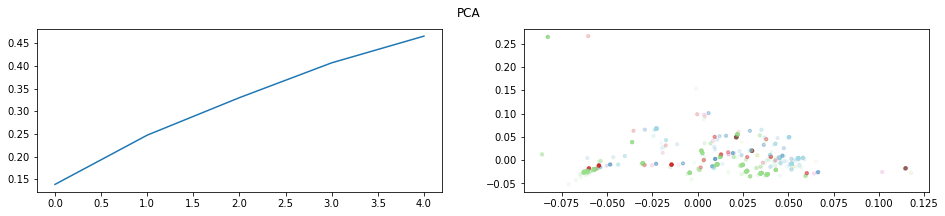

Finish PCA
------------------------------


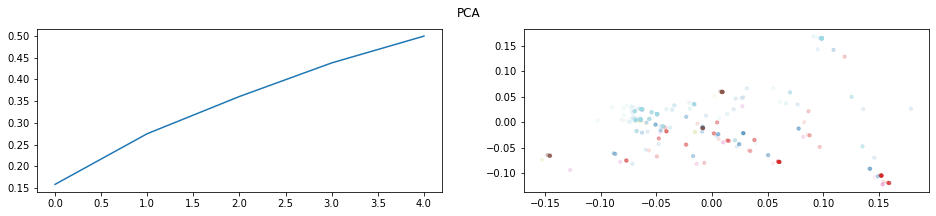

In [218]:
usage_PCA = show_PCA(usage, min(usage.shape[0], 50000), usage_color, 5)
usage_no_social_PCA = show_PCA(usage_no_social, min(usage_no_social.shape[0], 50000), usage_no_social_color, 5)

The above two graphs show that the we can reduce the dimension to 35 without losing too much information. Unfortunately we cannot see obvious clusters

Finish PCA
------------------------------


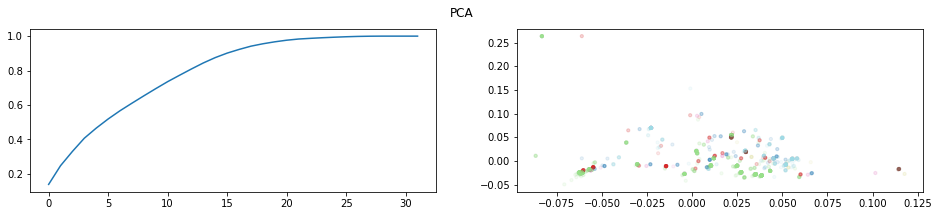

Finish PCA
------------------------------


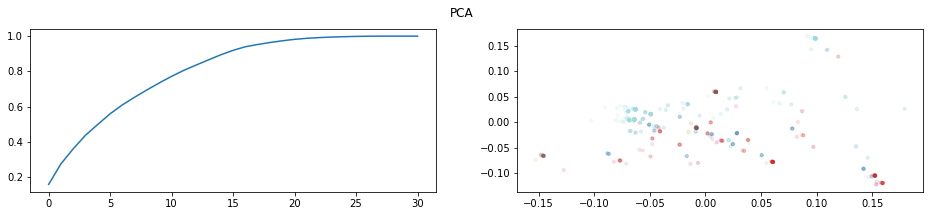

In [219]:
rm_usage_PCA = show_PCA(rm_usage, min(rm_usage.shape[0], 50000), rm_usage_color, rm_usage.shape[1])
rm_usage_no_social_PCA = show_PCA(rm_usage_no_social, min(rm_usage_no_social.shape[0], 50000), rm_usage_no_social_color, rm_usage_no_social.shape[1])

Runningt the same on the oscillation set of data, we can see there are slight increase in terms of the explained variance of the first components. Especially on all app categories. Does that mean most of the osciallation happend during social networking app usage?

Do we wanna remove some app categories by turning them to the same app_cat ID?

# Run SVD to study the components

In [220]:
# from sklearn.utils.extmath import randomized_svd

# U, Sigma, VT = randomized_svd(rm_usage_no_social, 
#                               n_components=20,
#                               random_state=None)

In [221]:
# # Take a look at the magnitude of the first component
# VT[0]

# Visualizing high dimensional data

In [227]:
def visualTSNE(method, components, data, color_feature):

    data_transformed = method(n_components=2, n_jobs=-1, random_state=0).fit_transform(data)
    plt.figure(figsize=(8,6))
    plt.scatter(data_transformed.T[0], data_transformed.T[1], \
        s=20, \
        c=np.array(color_feature), \
        cmap=plt.cm.tab20, \
        alpha=0.5)
    # plt.title(title)
    plt.show()

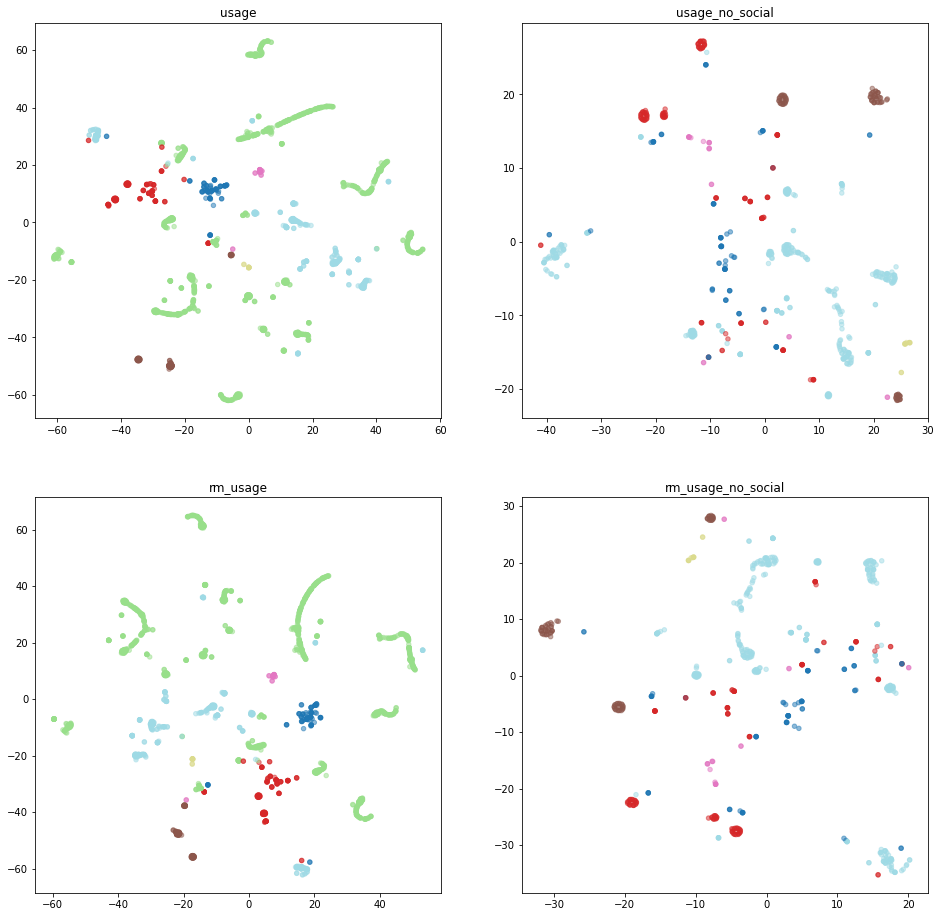

In [228]:
datasets = [usage, usage_no_social, rm_usage, rm_usage_no_social]
color_maps = [usage_color, usage_no_social_color, rm_usage_color, rm_usage_no_social_color]
titles = ['usage', 'usage_no_social', 'rm_usage', 'rm_usage_no_social']

fig, axs = plt.subplots(2,2, figsize=(16,16))

axs = axs.ravel()

for i, d in enumerate(zip(datasets, color_maps)):

    data_transformed = TSNE(n_components=2, n_jobs=-1).fit_transform(d[0])

    axs[i].scatter(data_transformed.T[0], data_transformed.T[1], \
        s=20, \
        c=np.array(d[1]), \
        cmap=plt.cm.tab20, \
        alpha=0.5)
    axs[i].set_title(titles[i])
plt.show()


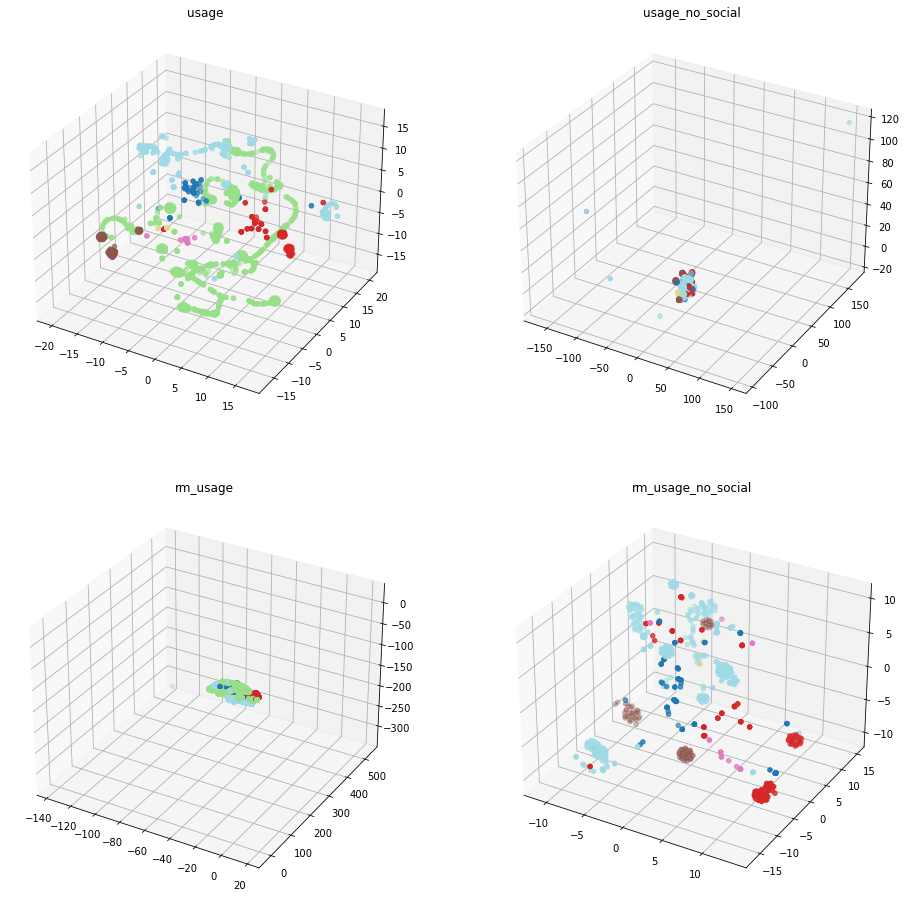

In [229]:
datasets = [usage, usage_no_social, rm_usage, rm_usage_no_social]
color_maps = [usage_color, usage_no_social_color, rm_usage_color, rm_usage_no_social_color]
titles = ['usage', 'usage_no_social', 'rm_usage', 'rm_usage_no_social']

fig = plt.figure(figsize=(16,16))

for i, d in enumerate(zip(datasets, color_maps)):

    data_transformed = TSNE(n_components=3, n_jobs=-1).fit_transform(d[0])

    ax = fig.add_subplot(2, 2, i+1, projection='3d')

    ax.scatter(data_transformed.T[0], data_transformed.T[1], data_transformed.T[2], \
        # s=20, \
        c=np.array(d[1]), \
        cmap=plt.cm.tab20, \
        # alpha=0.5)
    )
    ax.set_title(titles[i])
plt.show()


In [230]:
import plotly.express as px


In [231]:
datasets = [usage, usage_no_social, rm_usage, rm_usage_no_social]
color_maps = [usage_color, usage_no_social_color, rm_usage_color, rm_usage_no_social_color]
titles = ['usage', 'usage_no_social', 'rm_usage', 'rm_usage_no_social']

fig = plt.figure(figsize=(16,16))

for i, d in enumerate(zip(datasets, color_maps)):

    data_transformed = TSNE(n_components=3, n_jobs=-1).fit_transform(d[0])

    fig = px.scatter_3d(
        data_transformed, x=0, y=1, z=2,
        color=color_maps[i], \
    )
    fig.update_traces(marker_size=5)
    fig.show()



<Figure size 1152x1152 with 0 Axes>